<h1 style="text-align: center; color:rgb(254, 255, 255);">Insider Trades Analysis</h1>

### Automatic data collection with github actions

Scrape SEC form 4 insider purchases over $500k

In [1]:
import pandas as pd
def display_insider_trades():
    # Read the insider buys CSV file
    df = pd.read_csv('Scraping/insider_buys.csv')
    
    # Display the dataframe
    display(df)
display_insider_trades()

,Filing Date,Ticker,Company Name,Insider Name,Transaction Price,Price Bought,Value
0,2025-02-12 21:16:44,TKO,"Tko Group Holdings, Inc.",Whitesell Patrick,174.48,176.679993,68128471
1,2025-02-12 20:28:13,BPRN,"Princeton Bancorp, Inc.",Tuchman Martin,32.71,31.379999,719620
2,2025-02-12 17:24:03,FLWS,1 800 Flowers Com Inc,"Fund 1 Investments, LLC",8.11,8.230000,1135429
3,2025-02-12 17:21:33,SION,"Sionna Therapeutics, Inc.","Tpg Gp A, LLC",18.00,19.990000,20250000
4,2025-02-12 16:31:24,MTH,Meritage Homes Corp,Hilton Steven J,74.51,73.239998,819610
5,2025-02-12 16:05:59,AMCR,Amcor Plc,Konieczny Peter,10.05,9.990000,1004780
6,2025-02-12 14:22:51,MAGN,Magnera Corp,Begle Curt,21.08,21.930000,501297
7,2025-02-11 20:35:48,OXY,Occidental Petroleum Corp /De/,Berkshire Hathaway Inc,46.82,48.619999,35724074
8,2025-02-11 19:51:08,KALV,"Kalvista Pharmaceuticals, Inc.","Venrock Healthcare Capital Partners Iii, L.P.",9.26,9.290000,967145
9,2025-02-11 17:58:35,NVCT,"Nuvectis Pharma, Inc.",Mosseri Marlio Charles,5.00,6.300000,1200000


Calculate the change in price of the stock in 24h, 1 week and 1 month after the filing date.

In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import os

def calculate_price_changes():
    # Read the insider buys CSV file
    df = pd.read_csv('Scraping/insider_buys.csv')
    
    # Convert Filing Date to datetime
    df['Filing Date'] = pd.to_datetime(df['Filing Date'])
    
    # Initialize new columns
    df['24h_Change_%'] = None
    df['1w_Change_%'] = None
    df['1m_Change_%'] = None
    
    current_time = datetime.now()
    
    # Suppress yfinance warnings
    import logging
    logging.getLogger('yfinance').setLevel(logging.CRITICAL)
    
    for idx, row in df.iterrows():
        try:
            ticker = row['Ticker']
            filing_date = row['Filing Date']
            base_price = row['Price Bought']
            
            if pd.isna(base_price):
                continue
                
            stock = yf.Ticker(ticker)
            
            # Calculate target dates keeping exact hour and minute
            h24_target = filing_date + timedelta(days=1)
            w1_target = filing_date + timedelta(days=7)
            m1_target = filing_date + timedelta(days=30)
            
            # Check if filing was after market hours (after 16:00)
            is_after_hours = filing_date.hour >= 16
            is_friday = filing_date.weekday() == 4
            
            # Only calculate if the time has passed
            if h24_target < current_time:
                # For 24h change, extend the window if it's Friday after hours
                if is_friday and is_after_hours:
                    h24_target = filing_date + timedelta(days=3)  # Skip to Monday
                
                h24_data = stock.history(
                    start=(filing_date.date()).strftime('%Y-%m-%d'),
                    end=(h24_target + timedelta(days=1)).strftime('%Y-%m-%d'),
                    interval='1m'
                )
                
                if not h24_data.empty:
                    h24_data.index = h24_data.index.tz_localize(None)
                    
                    if is_after_hours:
                        # Get next trading day's data
                        next_trading_data = h24_data[h24_data.index.date > filing_date.date()]
                        if not next_trading_data.empty:
                            # Get the same time next trading day
                            target_time = filing_date.time()
                            next_day_times = next_trading_data.index.time
                            closest_time_idx = min(range(len(next_day_times)), 
                                                 key=lambda i: abs(next_day_times[i].hour*60 + next_day_times[i].minute - 
                                                                 target_time.hour*60 - target_time.minute))
                            target_price = next_trading_data.iloc[closest_time_idx]['Close']
                            change = round(((target_price - base_price) / base_price) * 100, 2)
                            df.at[idx, '24h_Change_%'] = f"{'+' if change >= 0 else ''}{change}%"
                    else:
                        # For regular hours, find closest time next day
                        target_times = h24_data[h24_data.index.date == h24_target.date()]
                        if not target_times.empty:
                            closest_time = target_times.index[target_times.index.get_indexer([h24_target], method='nearest')[0]]
                            target_price = h24_data.loc[closest_time]['Close']
                            change = round(((target_price - base_price) / base_price) * 100, 2)
                            df.at[idx, '24h_Change_%'] = f"{'+' if change >= 0 else ''}{change}%"
            
            # Weekly and monthly changes remain the same
            if w1_target < current_time:
                w1_data = stock.history(
                    start=(w1_target - timedelta(days=1)).strftime('%Y-%m-%d'),
                    end=(w1_target + timedelta(days=1)).strftime('%Y-%m-%d'),
                    interval='1m'
                )
                if not w1_data.empty:
                    w1_data.index = w1_data.index.tz_localize(None)
                    closest_time = w1_data.index[w1_data.index.get_indexer([w1_target], method='nearest')[0]]
                    target_price = w1_data.loc[closest_time]['Close']
                    change = round(((target_price - base_price) / base_price) * 100, 2)
                    df.at[idx, '1w_Change_%'] = f"{'+' if change >= 0 else ''}{change}%"
            
            if m1_target < current_time:
                m1_data = stock.history(
                    start=(m1_target - timedelta(days=1)).strftime('%Y-%m-%d'),
                    end=(m1_target + timedelta(days=1)).strftime('%Y-%m-%d'),
                    interval='1m'
                )
                if not m1_data.empty:
                    m1_data.index = m1_data.index.tz_localize(None)
                    closest_time = m1_data.index[m1_data.index.get_indexer([m1_target], method='nearest')[0]]
                    target_price = m1_data.loc[closest_time]['Close']
                    change = round(((target_price - base_price) / base_price) * 100, 2)
                    df.at[idx, '1m_Change_%'] = f"{'+' if change >= 0 else ''}{change}%"
                    
        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
            continue

    # Handle existing analysis file
    analysis_file = 'insider_buys_analysis.csv'
    if os.path.exists(analysis_file):
        existing_df = pd.read_csv(analysis_file)
        existing_df['Filing Date'] = pd.to_datetime(existing_df['Filing Date'])
        
        # Combine existing and new data
        combined_df = pd.concat([existing_df, df])
        
        # Remove duplicates based on Filing Date, Ticker, and Transaction Price
        combined_df = combined_df.drop_duplicates(
            subset=['Filing Date', 'Ticker', 'Transaction Price'], 
            keep='last'
        )
        
        # Sort by Filing Date (most recent first)
        combined_df = combined_df.sort_values('Filing Date', ascending=False)
        
        # Save combined data
        combined_df.to_csv(analysis_file, index=False)
    else:
        # If no existing file, save new data
        df.to_csv(analysis_file, index=False)
    
    return df

# Execute the analysis
analysis_df = calculate_price_changes()
pd.set_option('display.max_rows', None)

Calculating averages for the change in price of the stock in 24h, 1 week and 1 month after the filing date.

In [3]:
def calculate_averages(df):
    # Convert percentage strings to numbers
    def convert_percentage(x):
        if pd.isna(x):
            return None
        return float(x.strip('%').replace('+', ''))
    
    # Convert percentages to numbers for all columns
    h24_changes = df['24h_Change_%'].apply(convert_percentage)
    w1_changes = df['1w_Change_%'].apply(convert_percentage)
    m1_changes = df['1m_Change_%'].apply(convert_percentage)
    
    # Calculate averages
    h24_avg = h24_changes.mean()
    w1_avg = w1_changes.mean()
    m1_avg = m1_changes.mean()
    
    # Calculate win rates (excluding None values)
    h24_winrate = (h24_changes[h24_changes.notna()] > 0).mean() * 100 if not h24_changes.empty else None
    w1_winrate = (w1_changes[w1_changes.notna()] > 0).mean() * 100 if not w1_changes.empty else None
    m1_winrate = (m1_changes[m1_changes.notna()] > 0).mean() * 100 if not m1_changes.empty else None
    
    print("Average Changes:")
    print(f"24 Hours: {'+' if h24_avg >= 0 else ''}{h24_avg:.2f}% (Win Rate: {h24_winrate:.1f}%)")
    if not pd.isna(w1_avg):
        print(f"1 Week:   {'+' if w1_avg >= 0 else ''}{w1_avg:.2f}% (Win Rate: {w1_winrate:.1f}%)")
    if not pd.isna(m1_avg):
        print(f"1 Month:  {'+' if m1_avg >= 0 else ''}{m1_avg:.2f}% (Win Rate: {m1_winrate:.1f}%)")

# Execute the analysis
analysis_df = calculate_price_changes()
calculate_averages(analysis_df)

Average Changes:
24 Hours: +0.94% (Win Rate: 54.8%)
1 Week:   -7.31% (Win Rate: 25.0%)


C:\Users\Albert\AppData\Local\Temp\ipykernel_78156\827250652.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['24h', '1w', '1m'])



Statistical Summary:

24-Hour Returns:
count    33.000000
mean      1.127576
std       4.671568
min      -9.610000
25%      -1.060000
50%       0.500000
75%       4.030000
max      12.560000
Name: 24h_Change_num, dtype: float64

1-Week Returns:
count     4.000000
mean     -7.310000
std      10.559991
min     -20.120000
25%     -12.687500
50%      -7.030000
75%      -1.652500
max       4.940000
Name: 1w_Change_num, dtype: float64

1-Month Returns:
count       0
unique      0
top       NaN
freq      NaN
Name: 1m_Change_num, dtype: object

Insider Correlation Analysis:

Top 5 Insiders by Timing (min 2 trades):
                                               Avg Return  Trades  Win Rate
Insider Name                                                               
Fribourg Paul J                                      4.28       2       1.0
Johnson Lloyd Emerson                                1.11       2       0.5
Control Empresarial De Capitales S.A. De C.V.       -1.08       2       0.5


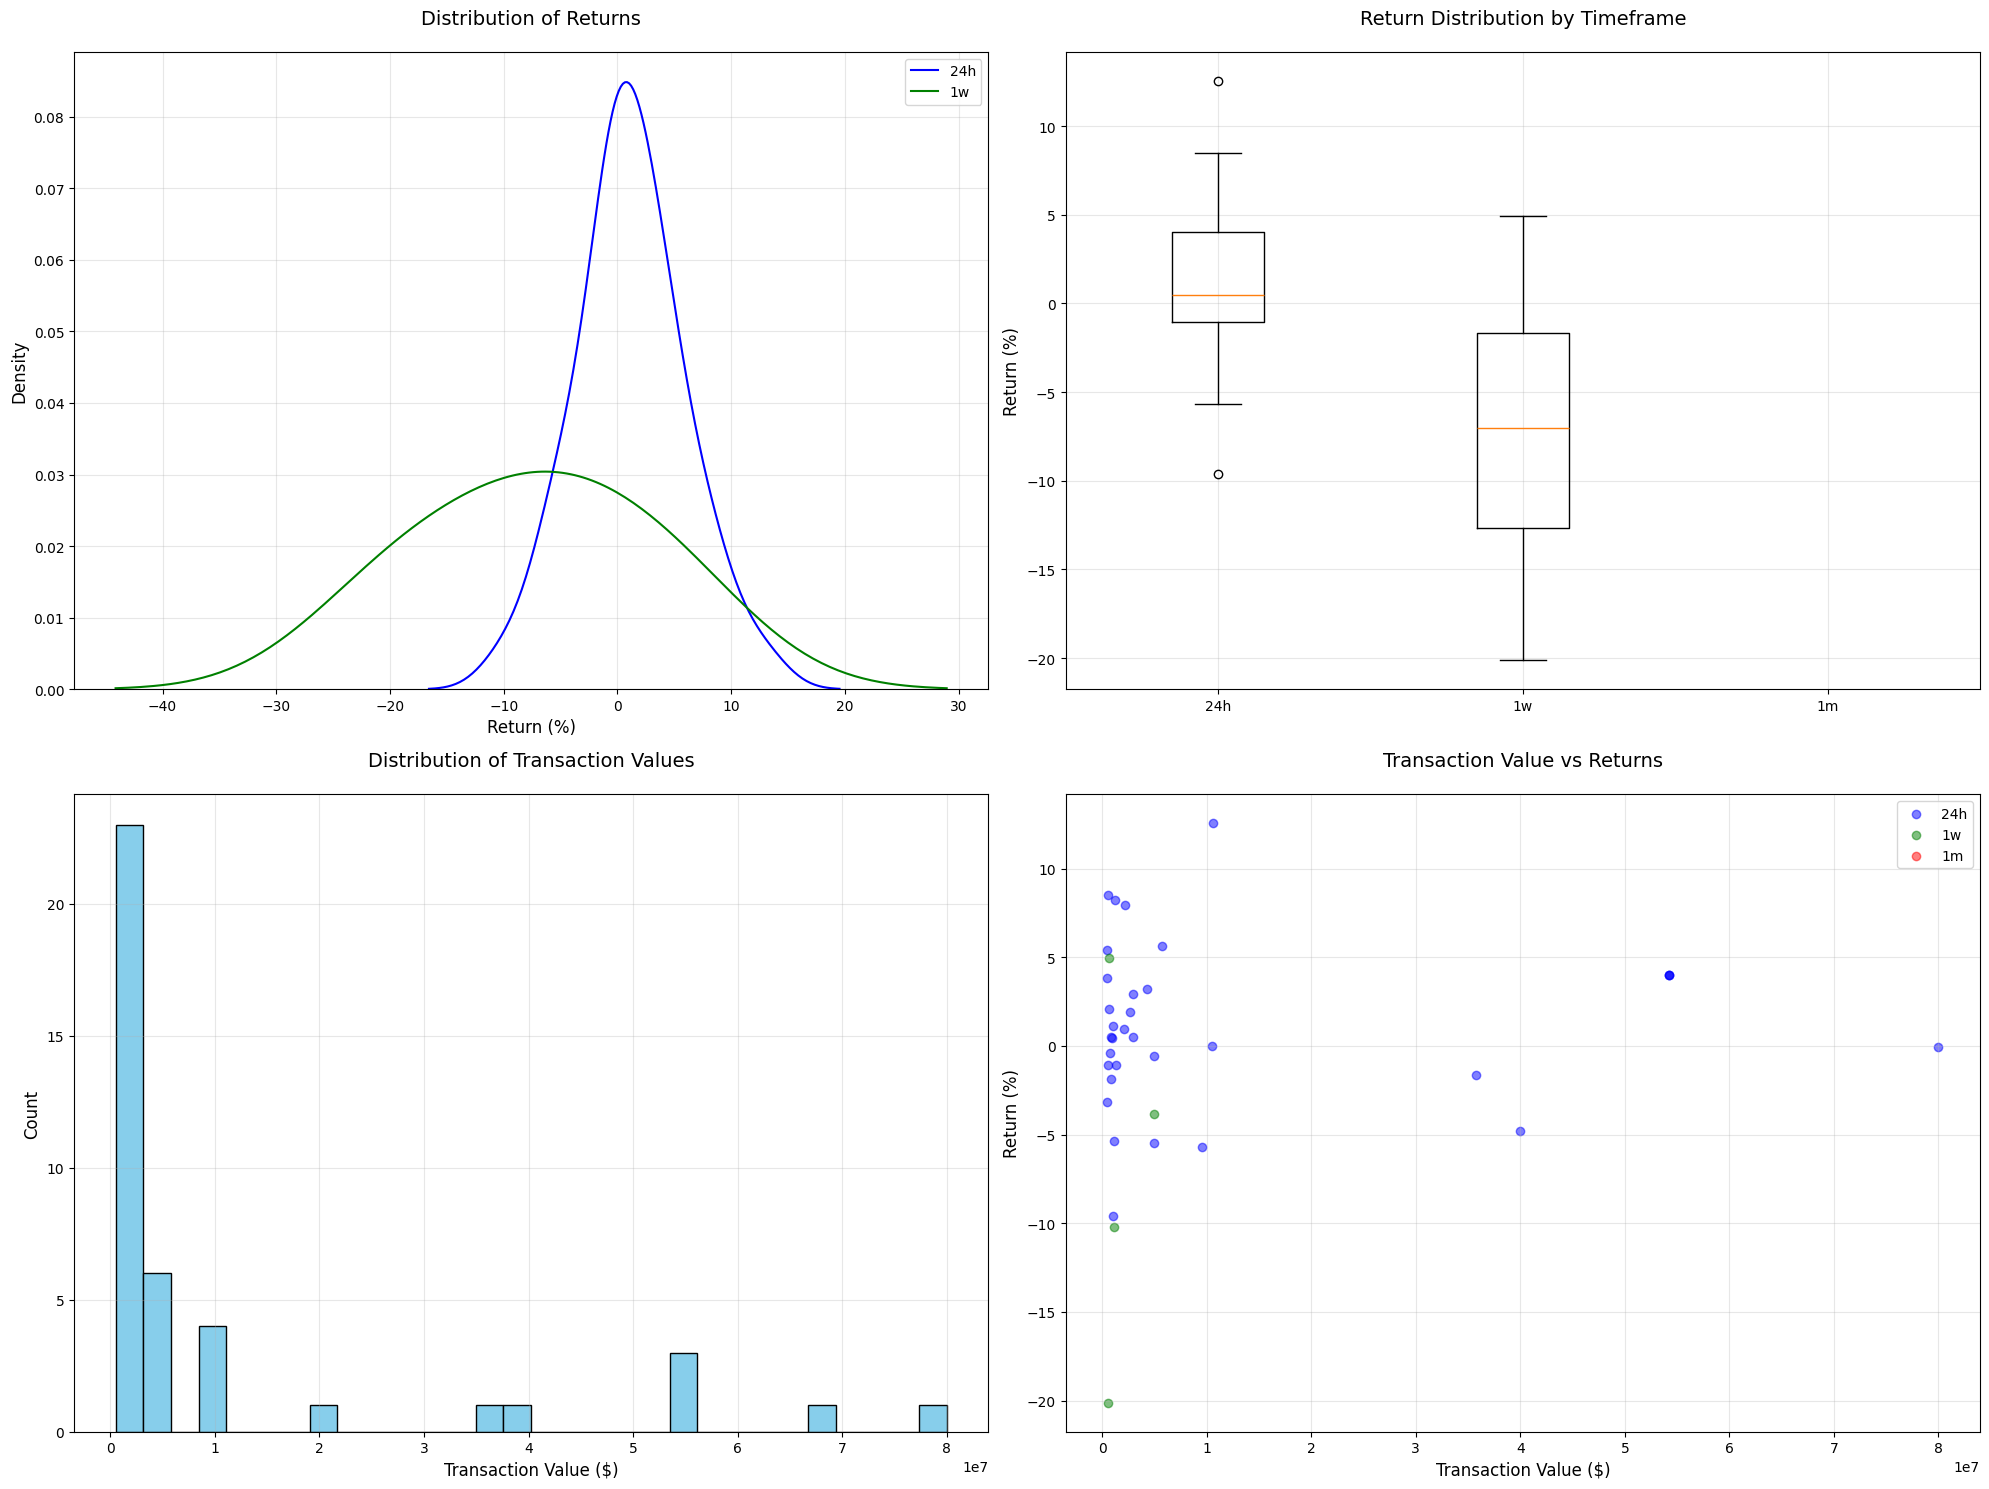

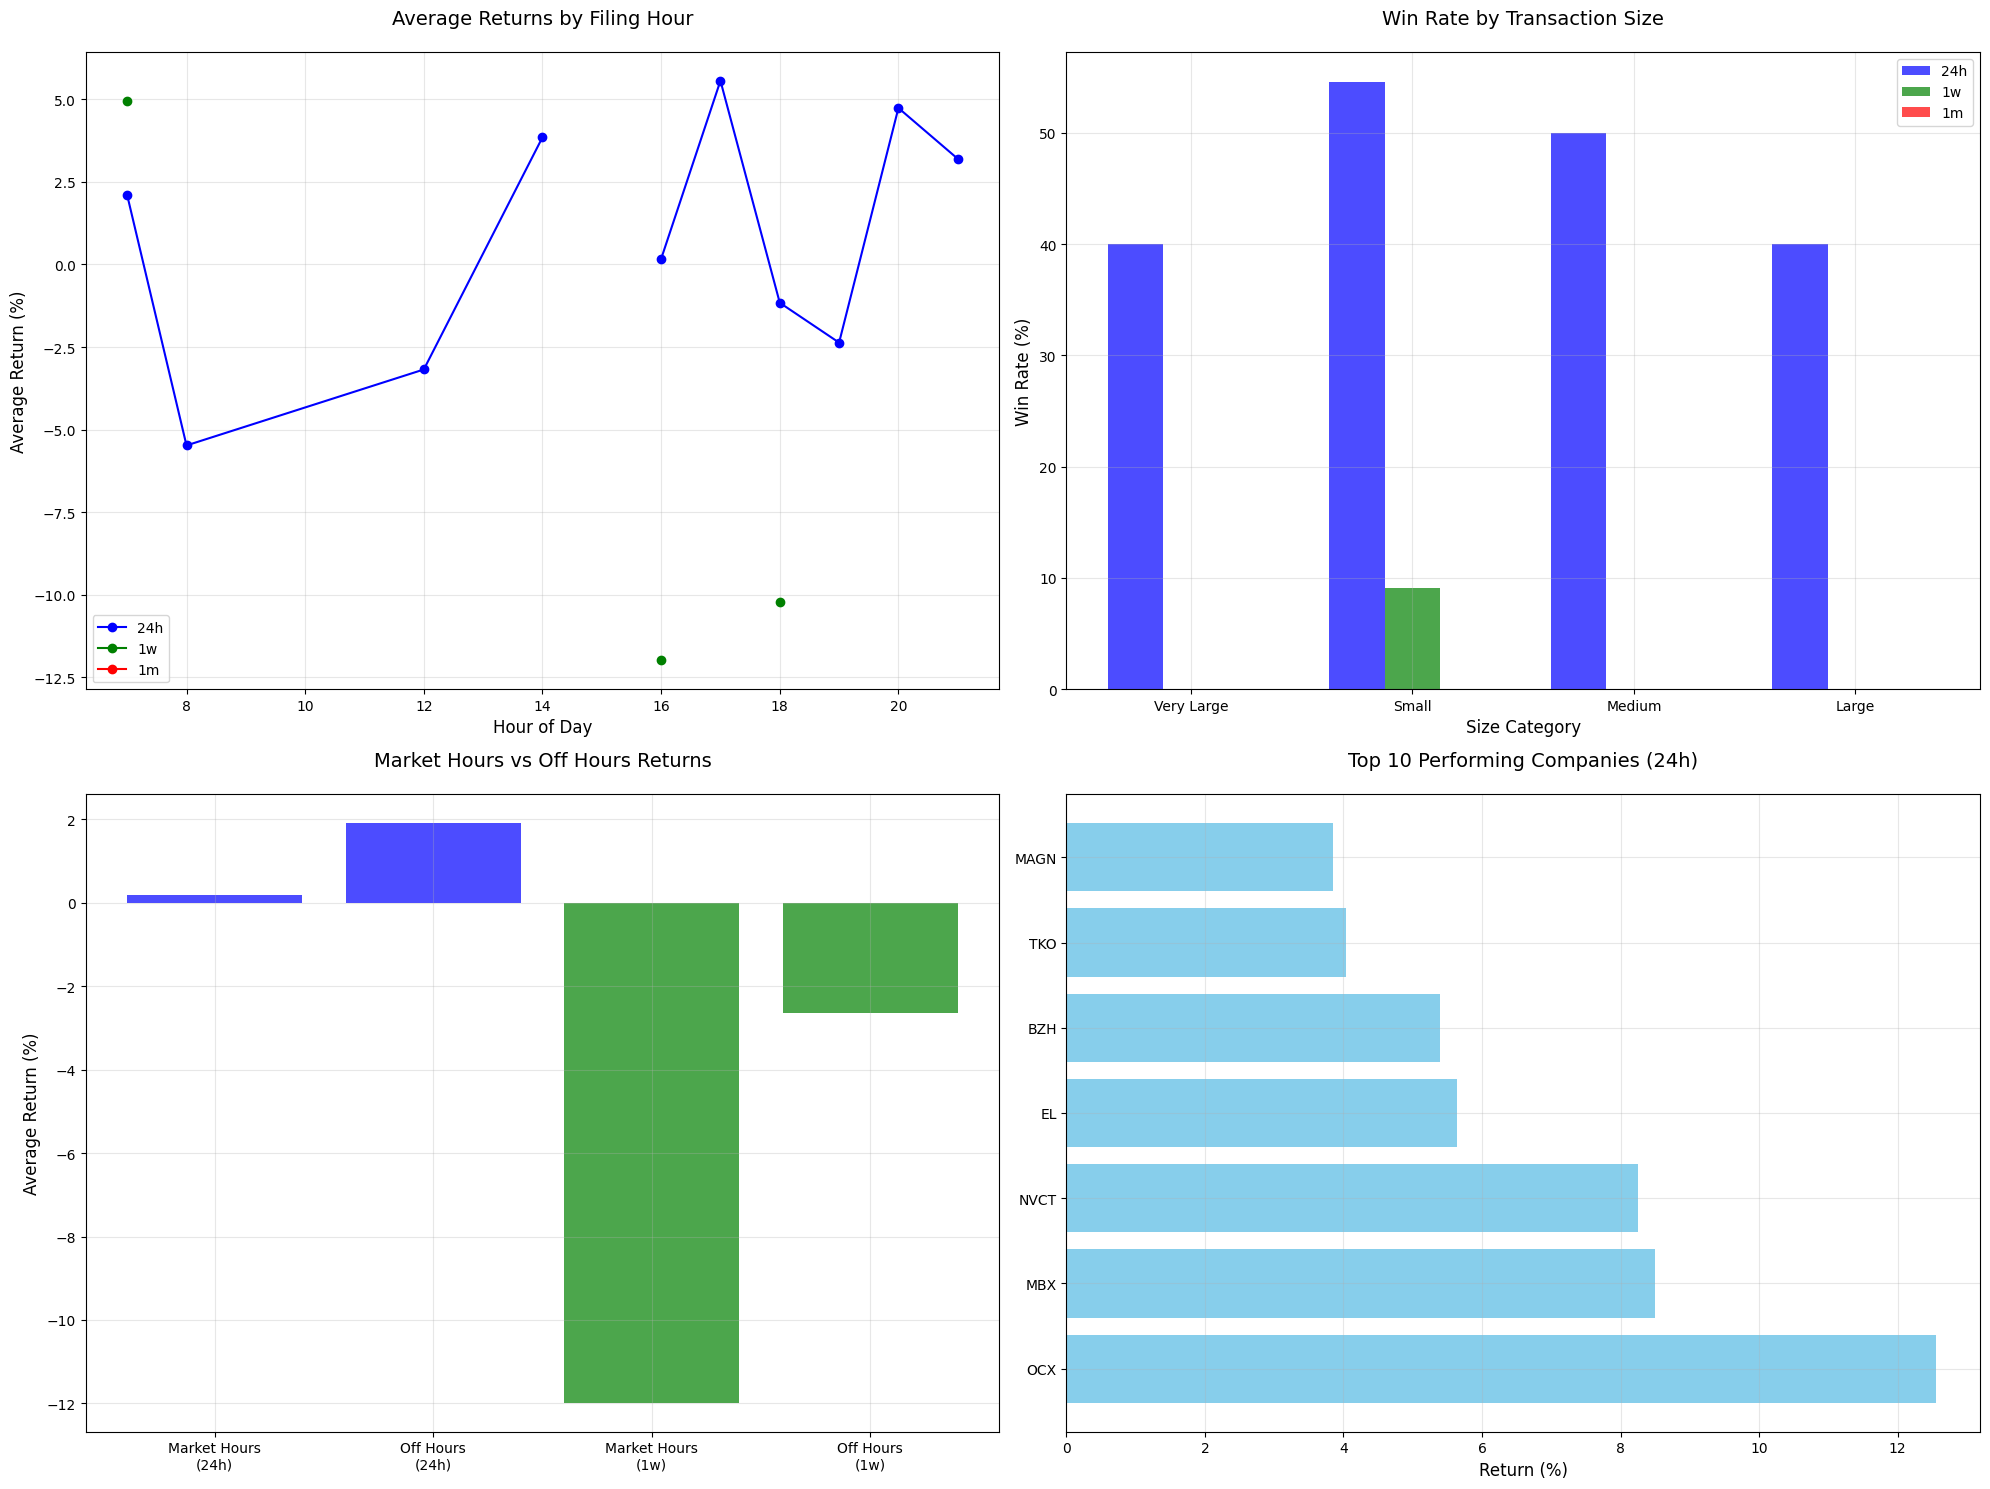

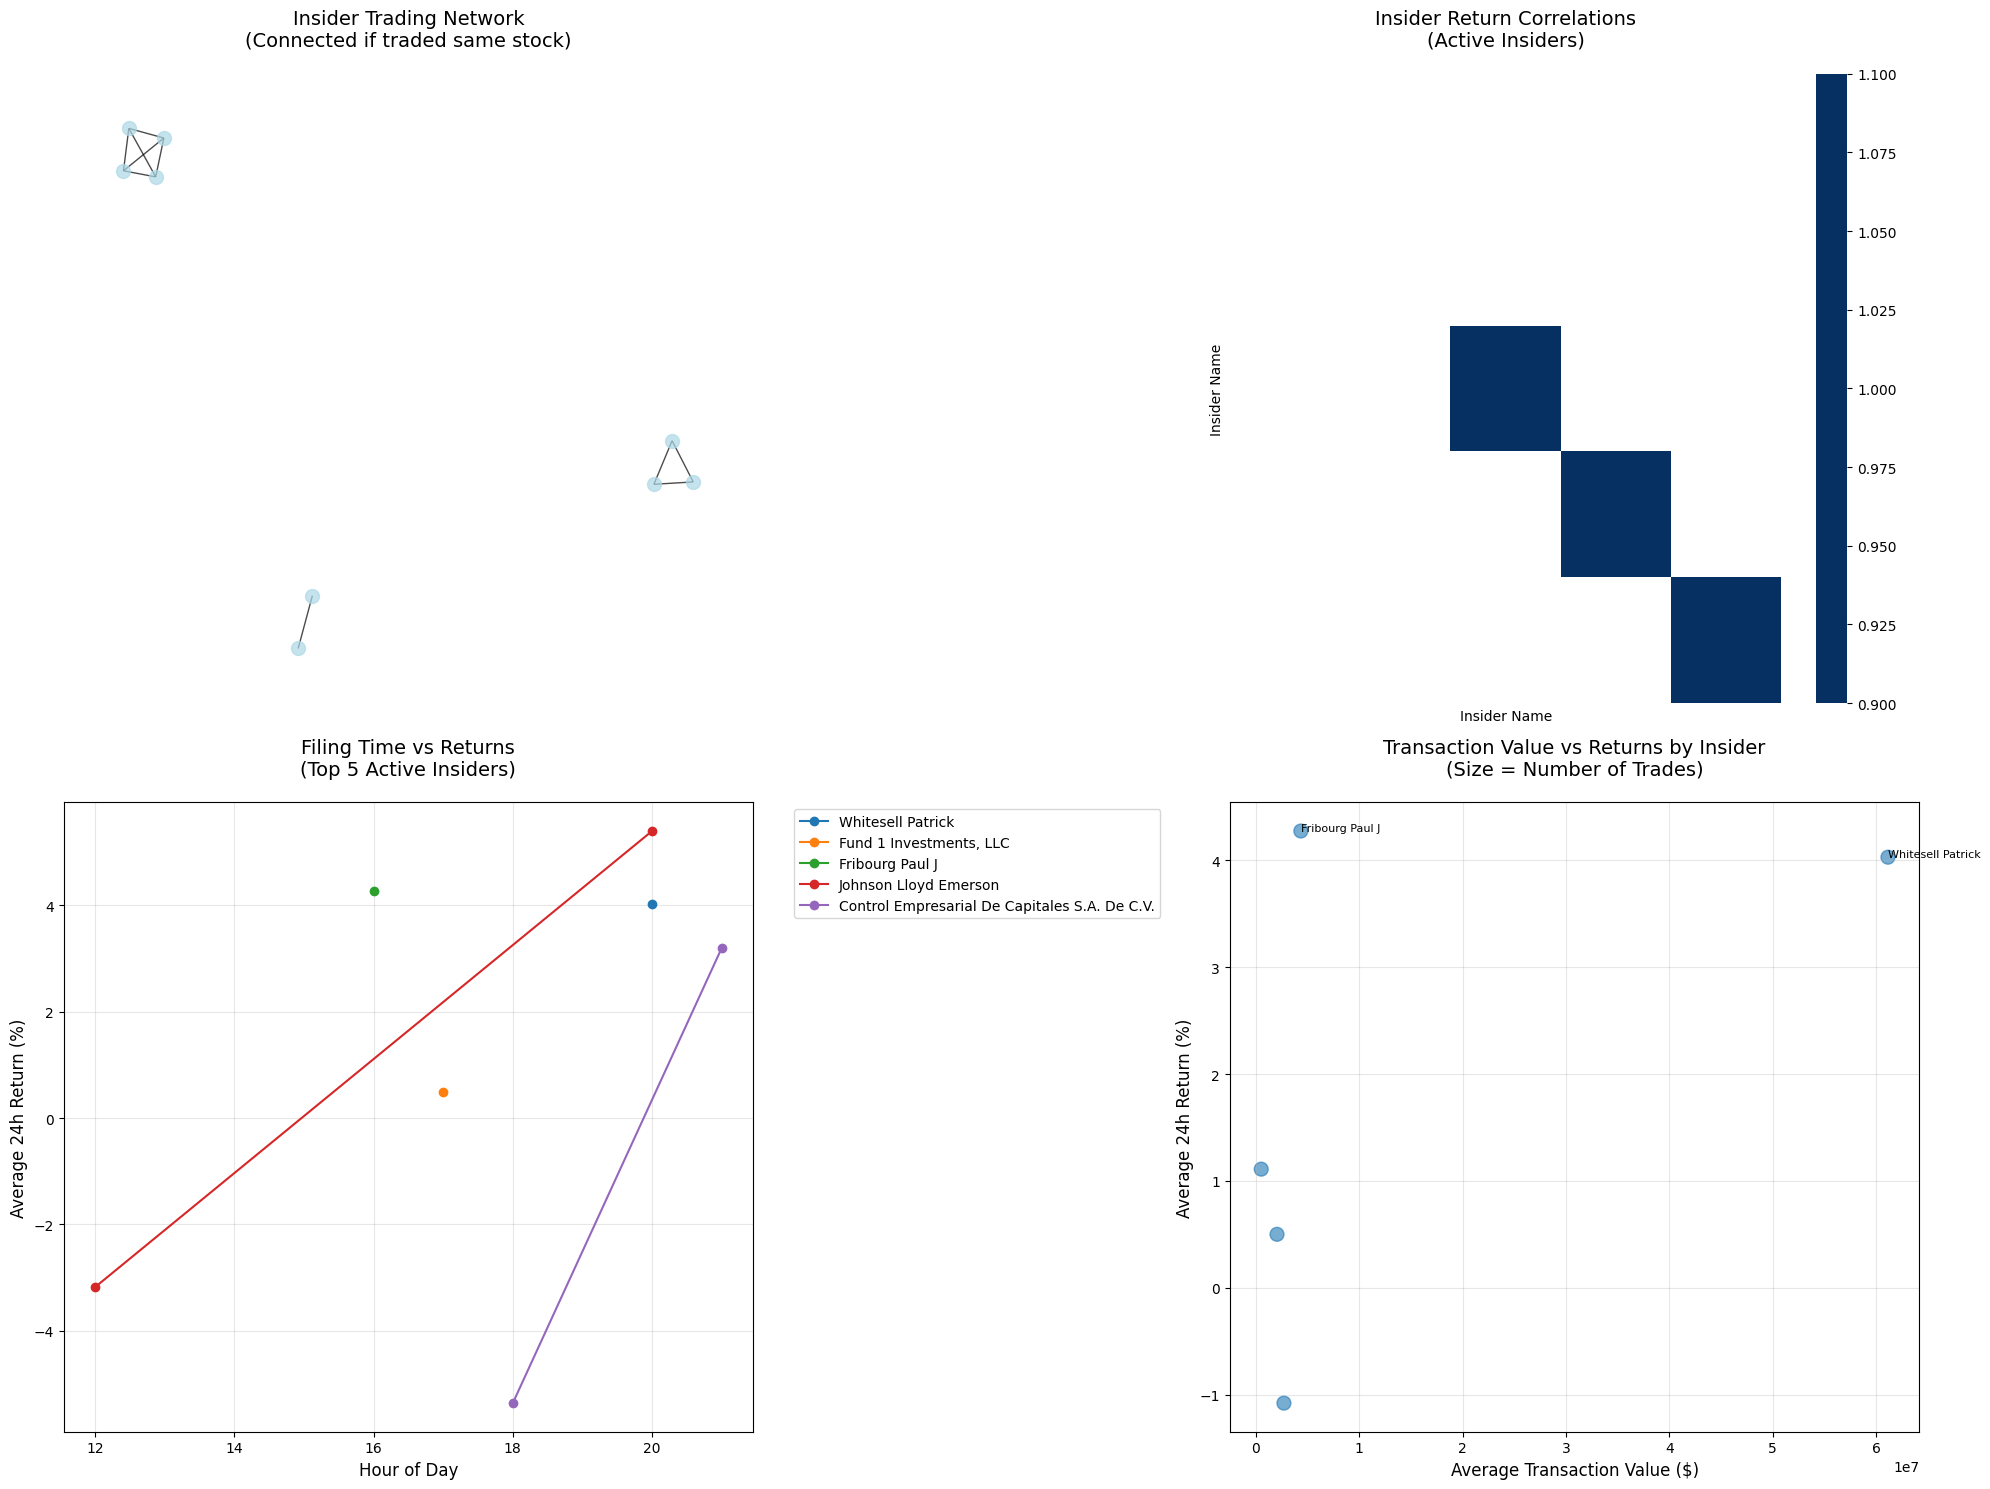

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import networkx as nx

def analyze_and_visualize_trades():
    # Read the data
    df = pd.read_csv('insider_buys_analysis.csv')
    df['Filing Date'] = pd.to_datetime(df['Filing Date'])
    
    # Convert percentage strings to numbers for analysis
    def convert_percentage(x):
        if pd.isna(x):
            return None
        return float(str(x).strip('%').replace('+', ''))
    
    df['24h_Change_num'] = df['24h_Change_%'].apply(convert_percentage)
    df['1w_Change_num'] = df['1w_Change_%'].apply(convert_percentage)
    df['1m_Change_num'] = df['1m_Change_%'].apply(convert_percentage)
    
    # Create size categories and time-related features
    df['Size_Category'] = pd.qcut(df['Value'], q=4, labels=['Small', 'Medium', 'Large', 'Very Large'])
    df['Filing_Hour'] = df['Filing Date'].dt.hour
    df['Trading_Hours'] = df['Filing_Hour'].apply(lambda x: 'Market Hours' if 9 <= x <= 16 else 'Off Hours')
    
    # Figure 1: Original Analysis
    plt.style.use('default')
    fig1 = plt.figure(figsize=(20, 15))
    
    # 1. Distribution of Returns
    plt.subplot(2, 2, 1)
    for col, label, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'], 
                                ['24h', '1w', '1m'], 
                                ['blue', 'green', 'red']):
        data = df[col].dropna()
        if not data.empty:
            sns.kdeplot(data=data, label=label, color=color)
    plt.title('Distribution of Returns', fontsize=14, pad=20)
    plt.xlabel('Return (%)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Box Plot of Returns
    plt.subplot(2, 2, 2)
    box_data = [df['24h_Change_num'].dropna(), 
                df['1w_Change_num'].dropna(), 
                df['1m_Change_num'].dropna()]
    plt.boxplot(box_data, labels=['24h', '1w', '1m'])
    plt.title('Return Distribution by Timeframe', fontsize=14, pad=20)
    plt.ylabel('Return (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 3. Transaction Value Distribution
    plt.subplot(2, 2, 3)
    plt.hist(df['Value'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Transaction Values', fontsize=14, pad=20)
    plt.xlabel('Transaction Value ($)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 4. Scatter plot of Transaction Value vs Returns
    plt.subplot(2, 2, 4)
    for col, label, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'],
                                ['24h', '1w', '1m'],
                                ['blue', 'green', 'red']):
        plt.scatter(df['Value'], df[col], alpha=0.5, label=label, color=color)
    plt.title('Transaction Value vs Returns', fontsize=14, pad=20)
    plt.xlabel('Transaction Value ($)', fontsize=12)
    plt.ylabel('Return (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Figure 2: Additional Analysis
    fig2 = plt.figure(figsize=(20, 15))
    
    # 1. Returns by Filing Hour
    plt.subplot(2, 2, 1)
    for col, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'], ['blue', 'green', 'red']):
        mean_returns = df.groupby('Filing_Hour')[col].mean()
        plt.plot(mean_returns.index, mean_returns.values, 'o-', label=col.split('_')[0], color=color)
    plt.title('Average Returns by Filing Hour', fontsize=14, pad=20)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Average Return (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Win Rate by Size Category
    plt.subplot(2, 2, 2)
    win_rates = []
    for col in ['24h_Change_num', '1w_Change_num', '1m_Change_num']:
        size_win_rates = []
        for category in df['Size_Category'].unique():
            data = df[df['Size_Category'] == category][col]
            win_rate = (data > 0).mean() * 100 if not data.empty else 0
            size_win_rates.append(win_rate)
        win_rates.append(size_win_rates)
    
    x = np.arange(len(df['Size_Category'].unique()))
    width = 0.25
    
    for i, (rates, label, color) in enumerate(zip(win_rates, 
                                                ['24h', '1w', '1m'],
                                                ['blue', 'green', 'red'])):
        plt.bar(x + i*width, rates, width, label=label, color=color, alpha=0.7)
    
    plt.title('Win Rate by Transaction Size', fontsize=14, pad=20)
    plt.xlabel('Size Category', fontsize=12)
    plt.ylabel('Win Rate (%)', fontsize=12)
    plt.xticks(x + width, df['Size_Category'].unique())
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Market Hours vs Off Hours Performance
    plt.subplot(2, 2, 3)
    for col, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'], ['blue', 'green', 'red']):
        market_means = [df[df['Trading_Hours'] == hours][col].mean() for hours in ['Market Hours', 'Off Hours']]
        plt.bar([f"Market Hours\n({col.split('_')[0]})", f"Off Hours\n({col.split('_')[0]})"], 
                market_means, alpha=0.7, color=color)
    plt.title('Market Hours vs Off Hours Returns', fontsize=14, pad=20)
    plt.ylabel('Average Return (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 4. Top Performing Companies
    plt.subplot(2, 2, 4)
    performance_24h = df[['Ticker', '24h_Change_num']].dropna()
    top_performers = performance_24h.nlargest(10, '24h_Change_num')
    plt.barh(top_performers['Ticker'], top_performers['24h_Change_num'], color='skyblue')
    plt.title('Top 10 Performing Companies (24h)', fontsize=14, pad=20)
    plt.xlabel('Return (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Figure 3: Insider Correlation Analysis
    fig3 = plt.figure(figsize=(20, 15))
    
    # 1. Insider Trading Network
    plt.subplot(2, 2, 1)
    insider_company = df.groupby(['Insider Name', 'Ticker']).size().reset_index()
    insider_company.columns = ['Insider', 'Company', 'Trades']
    
    # Create network graph
    G = nx.Graph()
    
    # Add edges for insiders who trade in the same companies
    insider_pairs = []
    companies = insider_company['Company'].unique()
    
    for company in companies:
        insiders = insider_company[insider_company['Company'] == company]['Insider'].tolist()
        for i in range(len(insiders)):
            for j in range(i+1, len(insiders)):
                insider_pairs.append((insiders[i], insiders[j]))
    
    # Add edges with weights
    for pair in insider_pairs:
        if G.has_edge(pair[0], pair[1]):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)
    
    # Draw the network
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=100, node_color='lightblue', 
            with_labels=False, alpha=0.7)
    
    # Label high-degree nodes
    degrees = dict(G.degree())
    high_degree_nodes = {node: degree for node, degree in degrees.items() 
                        if degree > np.percentile(list(degrees.values()), 75)}
    
    nx.draw_networkx_labels(G, pos, 
                           {node: node for node in high_degree_nodes},
                           font_size=8)
    
    plt.title('Insider Trading Network\n(Connected if traded same stock)', 
              fontsize=14, pad=20)
    
    # 2. Correlation Matrix
    plt.subplot(2, 2, 2)
    
    # Create pivot table of insider returns
    insider_returns = pd.pivot_table(
        df,
        values='24h_Change_num',
        index='Filing Date',
        columns='Insider Name',
        aggfunc='first'
    )
    
    # Calculate correlation matrix for insiders with multiple trades
    active_insiders = df['Insider Name'].value_counts()[df['Insider Name'].value_counts() > 1].index
    corr_matrix = insider_returns[active_insiders].corr()
    
    sns.heatmap(corr_matrix, cmap='RdBu', center=0, 
                xticklabels=False, yticklabels=False)
    plt.title('Insider Return Correlations\n(Active Insiders)', 
              fontsize=14, pad=20)
    
    # 3. Insider Timing Analysis
    plt.subplot(2, 2, 3)
    
    # Calculate average return by insider and hour
    timing_analysis = df.groupby(['Insider Name', 'Filing_Hour'])['24h_Change_num'].mean().reset_index()
    
    # Get top 5 insiders by number of trades
    top_insiders = df['Insider Name'].value_counts().head().index
    
    for insider in top_insiders:
        insider_data = timing_analysis[timing_analysis['Insider Name'] == insider]
        plt.plot(insider_data['Filing_Hour'], 
                insider_data['24h_Change_num'], 
                'o-', label=insider)
    
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Average 24h Return (%)', fontsize=12)
    plt.title('Filing Time vs Returns\n(Top 5 Active Insiders)', 
              fontsize=14, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 4. Insider Value vs Return
    plt.subplot(2, 2, 4)
    
    # Calculate average value and return by insider
    insider_metrics = df.groupby('Insider Name').agg({
        'Value': 'mean',
        '24h_Change_num': 'mean',
        'Ticker': 'count'
    }).reset_index()
    
    # Only include insiders with multiple trades
    insider_metrics = insider_metrics[insider_metrics['Ticker'] > 1]
    
    plt.scatter(insider_metrics['Value'], 
               insider_metrics['24h_Change_num'],
               s=insider_metrics['Ticker']*50,  # Size based on number of trades
               alpha=0.6)
    
    # Label outliers
    for idx, row in insider_metrics.iterrows():
        if (abs(row['24h_Change_num']) > np.percentile(abs(insider_metrics['24h_Change_num']), 75) or
            row['Value'] > np.percentile(insider_metrics['Value'], 75)):
            plt.annotate(row['Insider Name'], 
                        (row['Value'], row['24h_Change_num']),
                        fontsize=8)
    
    plt.xlabel('Average Transaction Value ($)', fontsize=12)
    plt.ylabel('Average 24h Return (%)', fontsize=12)
    plt.title('Transaction Value vs Returns by Insider\n(Size = Number of Trades)', 
              fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print statistical insights
    print("\nStatistical Summary:")
    print("\n24-Hour Returns:")
    print(df['24h_Change_num'].describe())
    
    print("\n1-Week Returns:")
    print(df['1w_Change_num'].describe())
    
    print("\n1-Month Returns:")
    print(df['1m_Change_num'].describe())
    
    print("\nInsider Correlation Analysis:")
    
    # Find highly correlated insider pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            correlation = corr_matrix.iloc[i,j]
            if abs(correlation) > 0.5:  # Threshold for high correlation
                high_corr_pairs.append({
                    'Insider 1': corr_matrix.columns[i],
                    'Insider 2': corr_matrix.columns[j],
                    'Correlation': correlation
                })
    
    if high_corr_pairs:
        print("\nHighly Correlated Insider Pairs:")
        for pair in sorted(high_corr_pairs, key=lambda x: abs(x['Correlation']), reverse=True)[:5]:
            print(f"{pair['Insider 1']} and {pair['Insider 2']}: {pair['Correlation']:.2f}")
    
    # Find insiders with best timing
    timing_success = df.groupby('Insider Name').agg({
        '24h_Change_num': ['mean', 'count', lambda x: (x > 0).mean()]
    }).round(2)
    timing_success.columns = ['Avg Return', 'Trades', 'Win Rate']
    timing_success = timing_success[timing_success['Trades'] > 1]
    
    print("\nTop 5 Insiders by Timing (min 2 trades):")
    print(timing_success.sort_values('Avg Return', ascending=False).head())
    
    plt.show()

# Run the analysis
analyze_and_visualize_trades()

Total available trades: 41
Date range: 2025-02-05 to 2025-02-12

Total trades executed: 33

Performance Analysis:

Performance by Trade Size:
               Avg Return  Count   Win Rate
size_category                              
Small            1.401818     11  63.636364
Medium           0.380909     11  63.636364
Large            1.600000     11  45.454545

Performance by Filing Hour:
             Avg Return  Count    Win Rate
filing_hour                               
17             5.563333      3  100.000000
20             4.738333      6   83.333333
14             3.850000      1  100.000000
21             3.200000      1  100.000000
7              2.100000      1  100.000000
16             0.167692     13   46.153846
18            -1.160000      3   33.333333
19            -2.366667      3   33.333333
12            -3.180000      1    0.000000
8             -5.480000      1    0.000000

Portfolio Performance Metrics:
Simulation Period: 7 days
Starting Capital: $100.00
Ending Ca

C:\Users\Albert\AppData\Local\Temp\ipykernel_7248\2943970805.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_performance = trades_df.groupby('size_category')['return'].agg(['mean', 'count', lambda x: (x > 0).mean() * 100])
C:\Users\Albert\AppData\Local\Temp\ipykernel_7248\2943970805.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_returns = trades_df.groupby('size_category')['return'].mean()


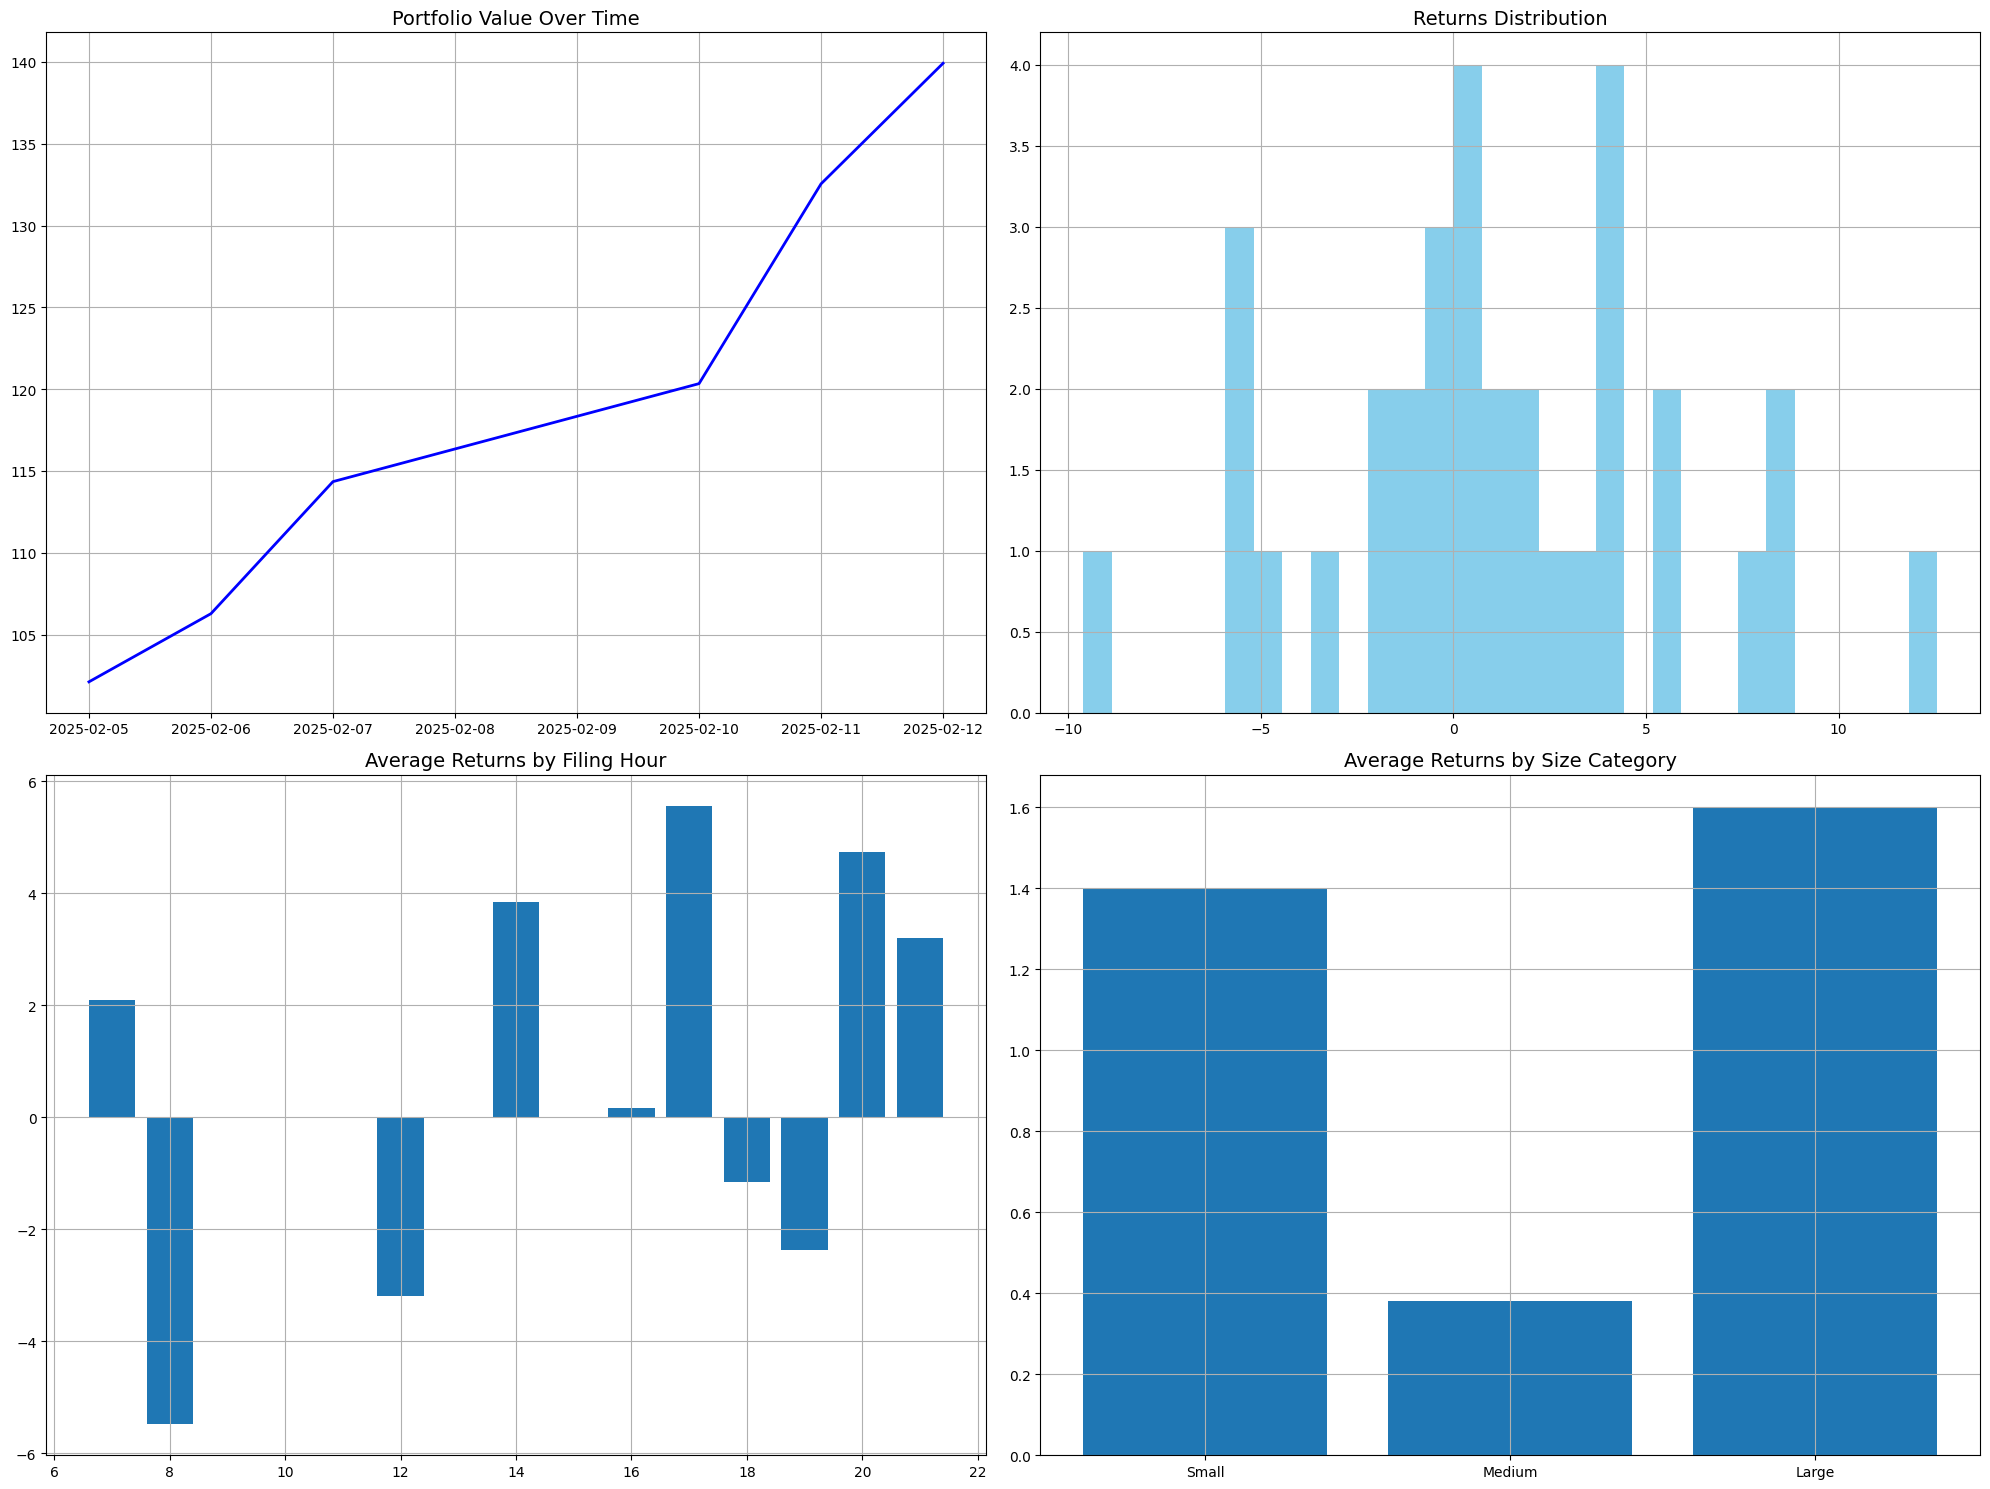

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def simulate_portfolio_v6():
    # Read and prepare data
    df = pd.read_csv('insider_buys_analysis.csv')
    df['Filing Date'] = pd.to_datetime(df['Filing Date'])
    
    def convert_percentage(x):
        if pd.isna(x):
            return None
        return float(str(x).strip('%').replace('+', ''))
    
    df['24h_Change_num'] = df['24h_Change_%'].apply(convert_percentage)
    df['Filing_Hour'] = df['Filing Date'].dt.hour
    
    # Sort by filing date
    df = df.sort_values('Filing Date')
    
    # Initialize portfolio
    initial_capital = 100
    portfolio_value = initial_capital
    portfolio_history = []
    trades_made = []
    
    current_positions = []
    current_date = None
    
    # Track simulation period
    start_date = df['Filing Date'].min()
    end_date = df['Filing Date'].max()
    days_simulated = (end_date - start_date).days
    
    # Print initial data check
    print(f"Total available trades: {len(df)}")
    print(f"Date range: {start_date.date()} to {end_date.date()}")
    
    # Simulate trading day by day
    for idx, row in df.iterrows():
        date = row['Filing Date'].date()
        
        # Close positions from previous day
        if current_date is not None and date != current_date:
            day_return = 0
            for position in current_positions:
                if not pd.isna(position['return']):
                    position_return = position['return']/100
                    portfolio_value *= (1 + position_return)
                    day_return += position_return
            
            if current_positions:
                daily_return = day_return / len(current_positions)
                portfolio_history.append({
                    'date': current_date,
                    'value': portfolio_value,
                    'trades': len(current_positions),
                    'daily_return': daily_return
                })
            
            current_positions = []
        
        current_date = date
        
        # Take all valid trades
        if not pd.isna(row['24h_Change_num']):
            current_positions.append({
                'ticker': row['Ticker'],
                'return': row['24h_Change_num'],
                'value': row['Value'],
                'filing_hour': row['Filing_Hour']
            })
            
            trades_made.append({
                'date': date,
                'ticker': row['Ticker'],
                'return': row['24h_Change_num'],
                'value': row['Value'],
                'filing_hour': row['Filing_Hour']
            })
    
    # Handle final positions
    if current_positions:
        day_return = 0
        for position in current_positions:
            if not pd.isna(position['return']):
                position_return = position['return']/100
                portfolio_value *= (1 + position_return)
                day_return += position_return
        
        daily_return = day_return / len(current_positions)
        portfolio_history.append({
            'date': current_date,
            'value': portfolio_value,
            'trades': len(current_positions),
            'daily_return': daily_return
        })
    
    # Convert to DataFrame for analysis
    portfolio_df = pd.DataFrame(portfolio_history)
    trades_df = pd.DataFrame(trades_made)
    
    print(f"\nTotal trades executed: {len(trades_df)}")
    
    if len(trades_df) == 0:
        print("No trades were executed.")
        return None, None
    
    # Performance metrics
    total_return = ((portfolio_value - initial_capital) / initial_capital) * 100
    num_trades = len(trades_df)
    win_rate = (trades_df['return'] > 0).mean() * 100 if not trades_df.empty else 0
    avg_return_per_trade = trades_df['return'].mean() if not trades_df.empty else 0
    
    # Analyze trade performance by various factors
    print("\nPerformance Analysis:")
    
    # By trade size
    trades_df['size_category'] = pd.qcut(trades_df['value'], q=3, labels=['Small', 'Medium', 'Large'])
    size_performance = trades_df.groupby('size_category')['return'].agg(['mean', 'count', lambda x: (x > 0).mean() * 100])
    size_performance.columns = ['Avg Return', 'Count', 'Win Rate']
    print("\nPerformance by Trade Size:")
    print(size_performance)
    
    # By hour
    hour_performance = trades_df.groupby('filing_hour')['return'].agg(['mean', 'count', lambda x: (x > 0).mean() * 100])
    hour_performance.columns = ['Avg Return', 'Count', 'Win Rate']
    print("\nPerformance by Filing Hour:")
    print(hour_performance.sort_values('Avg Return', ascending=False))
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Portfolio Value
    axes[0,0].plot(portfolio_df['date'], portfolio_df['value'], 'b-', linewidth=2)
    axes[0,0].set_title('Portfolio Value Over Time', fontsize=14)
    axes[0,0].grid(True)
    
    # Returns Distribution
    axes[0,1].hist(trades_df['return'], bins=30, color='skyblue')
    axes[0,1].set_title('Returns Distribution', fontsize=14)
    axes[0,1].grid(True)
    
    # Returns by Hour
    hour_returns = trades_df.groupby('filing_hour')['return'].mean()
    axes[1,0].bar(hour_returns.index, hour_returns.values)
    axes[1,0].set_title('Average Returns by Filing Hour', fontsize=14)
    axes[1,0].grid(True)
    
    # Returns by Size Category
    size_returns = trades_df.groupby('size_category')['return'].mean()
    axes[1,1].bar(size_returns.index, size_returns.values)
    axes[1,1].set_title('Average Returns by Size Category', fontsize=14)
    axes[1,1].grid(True)
    
    plt.tight_layout()
    
    # Print performance metrics
    print("\nPortfolio Performance Metrics:")
    print(f"Simulation Period: {days_simulated} days")
    print(f"Starting Capital: ${initial_capital:.2f}")
    print(f"Ending Capital: ${portfolio_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Number of Trades: {num_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Average Return per Trade: {avg_return_per_trade:.2f}%")
    print(f"Average Trades per Day: {num_trades/days_simulated:.2f}")
    
    return portfolio_df, trades_df

# Run the simulation
portfolio_df, trades_df = simulate_portfolio_v6()